Saved sorted normal data to: ./NAFZ_7SNR_3SAC/sac_data_filtered.csv
Saved sorted outlier data to: ./NAFZ_7SNR_3SAC/sac_data_outliers.csv


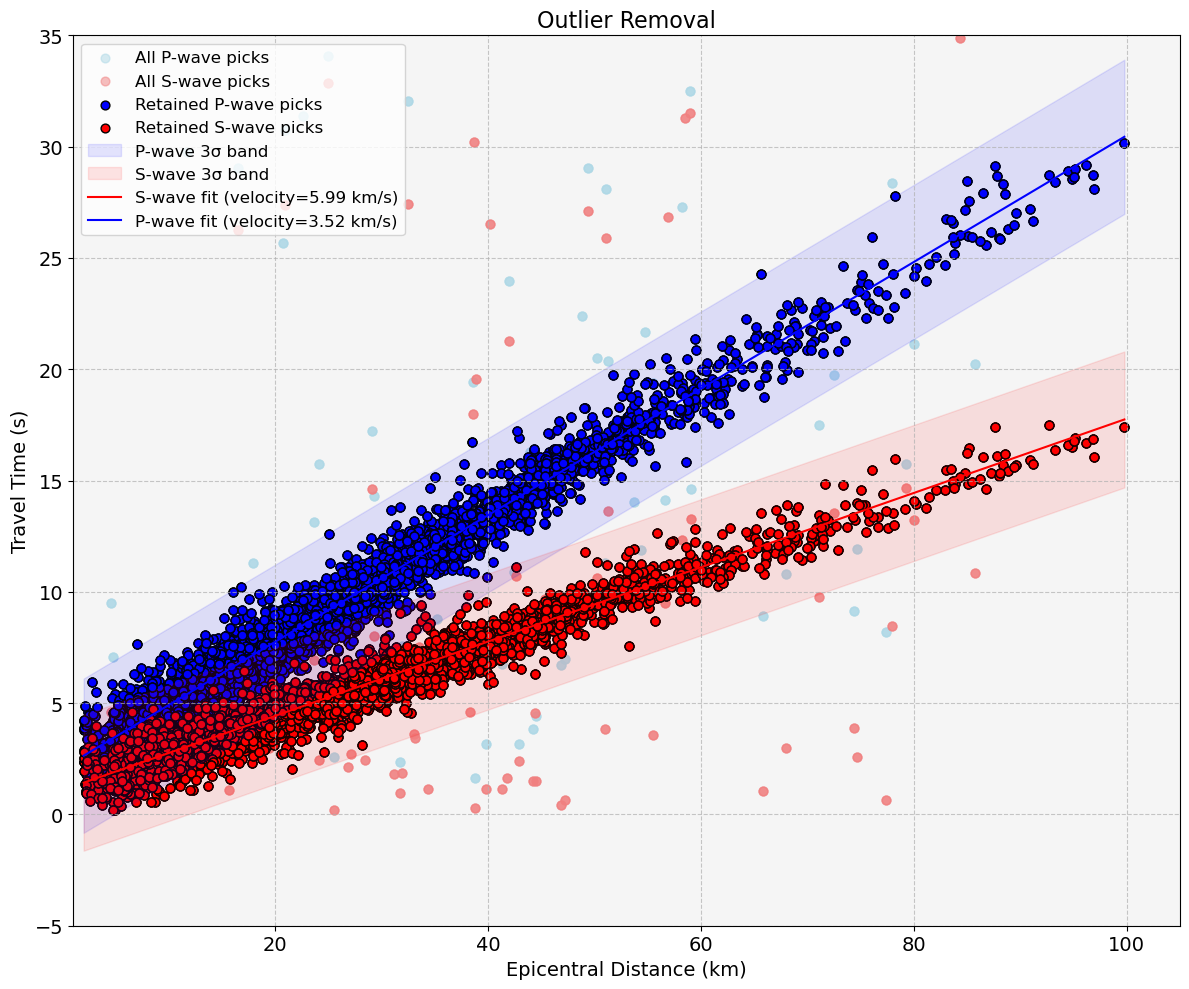

Velocity for S-wave: 5.99 km/s
Velocity for P-wave: 3.52 km/s
Vp/Vs ratio: 0.59
Copied SAC file: YH.DA01.2012-05-21T13:31.BHE.SAC
Copied SAC file: YH.DA01.2012-05-21T13:31.BHN.SAC
Copied SAC file: YH.DA01.2012-05-21T13:31.BHZ.SAC
Copied SAC file: YH.DA01.2012-05-22T08:56.BHE.SAC
Copied SAC file: YH.DA01.2012-05-22T08:56.BHN.SAC
Copied SAC file: YH.DA01.2012-05-22T08:56.BHZ.SAC
Copied SAC file: YH.DA01.2012-06-13T15:54.BHE.SAC
Copied SAC file: YH.DA01.2012-06-13T15:54.BHN.SAC
Copied SAC file: YH.DA01.2012-06-13T15:54.BHZ.SAC
Copied SAC file: YH.DA01.2012-06-14T07:40.BHE.SAC
Copied SAC file: YH.DA01.2012-06-14T07:40.BHN.SAC
Copied SAC file: YH.DA01.2012-06-14T07:40.BHZ.SAC
Copied SAC file: YH.DA01.2012-06-23T06:41.BHE.SAC
Copied SAC file: YH.DA01.2012-06-23T06:41.BHN.SAC
Copied SAC file: YH.DA01.2012-06-23T06:41.BHZ.SAC
Copied SAC file: YH.DA01.2012-06-28T17:46.BHE.SAC
Copied SAC file: YH.DA01.2012-06-28T17:46.BHN.SAC
Copied SAC file: YH.DA01.2012-06-28T17:46.BHZ.SAC
Copied SAC file: YH.

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from scipy import stats
import shutil

def get_sac_header_values(sac_file_path):
    try:
        st = read(sac_file_path)
        tr = st[0]
        o_value = tr.stats.sac.o
        t1_value = tr.stats.sac.t1
        t2_value = tr.stats.sac.t2
        dist_value = tr.stats.sac.dist
        return o_value, t1_value, t2_value, dist_value
    except Exception as e:
        print(f"Error processing file {sac_file_path}: {e}")
        return None, None, None, None

def remove_outliers_slope_shift(df, p_shift, s_shift):
    slope_p, intercept_p, _, _, _ = stats.linregress(df['Distance'], df['t2_minus_O'])
    slope_s, intercept_s, _, _, _ = stats.linregress(df['Distance'], df['t1_minus_O'])
    
    df['P_lower'] = slope_p * df['Distance'] + intercept_p - p_shift / slope_p
    df['P_upper'] = slope_p * df['Distance'] + intercept_p + p_shift / slope_p
    df['S_lower'] = slope_s * df['Distance'] + intercept_s - s_shift / slope_s
    df['S_upper'] = slope_s * df['Distance'] + intercept_s + s_shift / slope_s
    
    normal_df = df[(df['t2_minus_O'] >= df['P_lower']) & 
                   (df['t2_minus_O'] <= df['P_upper']) & 
                   (df['t1_minus_O'] >= df['S_lower']) & 
                   (df['t1_minus_O'] <= df['S_upper'])]
    
    outlier_df = df[~df.index.isin(normal_df.index)]
    
    return normal_df, outlier_df, slope_p, intercept_p, slope_s, intercept_s

def remove_outliers_std_dev(df, std_dev_threshold=3):
    def calc_residuals(x, y, slope, intercept):
        return y - (slope * x + intercept)

    slope_p, intercept_p, _, _, _ = stats.linregress(df['Distance'], df['t2_minus_O'])
    slope_s, intercept_s, _, _, _ = stats.linregress(df['Distance'], df['t1_minus_O'])
    
    p_residuals = calc_residuals(df['Distance'], df['t2_minus_O'], slope_p, intercept_p)
    s_residuals = calc_residuals(df['Distance'], df['t1_minus_O'], slope_s, intercept_s)
    
    p_std = np.std(p_residuals)
    s_std = np.std(s_residuals)
    
    normal_mask = (np.abs(p_residuals) <= std_dev_threshold * p_std) & \
                  (np.abs(s_residuals) <= std_dev_threshold * s_std)
    
    normal_df = df[normal_mask]
    outlier_df = df[~normal_mask]
    
    return normal_df, outlier_df, slope_p, intercept_p, slope_s, intercept_s

def remove_outliers_and_regress(df, method, **kwargs):
    if method == "slope_shift":
        normal_df, outlier_df, _, _, _, _ = remove_outliers_slope_shift(df, kwargs['p_shift'], kwargs['s_shift'])
    elif method == "std_dev":
        normal_df, outlier_df, _, _, _, _ = remove_outliers_std_dev(df, kwargs['std_dev_threshold'])
    else:
        raise ValueError("Invalid method specified")

    # Linear regression on filtered data
    slope_p, intercept_p, _, _, _ = stats.linregress(normal_df['Distance'], normal_df['t2_minus_O'])
    slope_s, intercept_s, _, _, _ = stats.linregress(normal_df['Distance'], normal_df['t1_minus_O'])

    return normal_df, outlier_df, slope_p, intercept_p, slope_s, intercept_s

def process_sac_directory(directory_path, csv_file_path, outlier_file_path, method, **kwargs):
    t1_minus_o = []
    t2_minus_o = []
    dists = []
    filenames = []

    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist.")
        return [], [], []

    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file() and entry.name.endswith(".SAC"):
                sac_file_path = entry.path
                o_value, t1_value, t2_value, dist_value = get_sac_header_values(sac_file_path)
                if None not in (o_value, t1_value, t2_value, dist_value):
                    t1_minus_o_value = t1_value - o_value
                    t2_minus_o_value = t2_value - o_value
                    if t1_minus_o_value > 0 and t2_minus_o_value > 0:
                        t1_minus_o.append(t1_minus_o_value)
                        t2_minus_o.append(t2_minus_o_value)
                        dists.append(dist_value)
                        filenames.append(entry.name)

    df = pd.DataFrame({
        "Filename": filenames,
        "Distance": dists,
        "t1_minus_O": t1_minus_o,
        "t2_minus_O": t2_minus_o,
    })

    normal_df, outlier_df, slope_p, intercept_p, slope_s, intercept_s = remove_outliers_and_regress(df, method, **kwargs)

    normal_df_sorted = normal_df.sort_values(by='Filename')
    normal_df_sorted.to_csv(csv_file_path, index=False)
    
    outlier_df_sorted = outlier_df.sort_values(by='Filename')
    outlier_df_sorted.to_csv(outlier_file_path, index=False)

    print(f"Saved sorted normal data to: {csv_file_path}")
    print(f"Saved sorted outlier data to: {outlier_file_path}")

    result = (normal_df_sorted['t1_minus_O'].tolist(), normal_df_sorted['t2_minus_O'].tolist(), 
              normal_df_sorted['Distance'].tolist(), slope_p, intercept_p, slope_s, intercept_s)
    
    return result, df

def plot_data(t1_minus_o, t2_minus_o, dists, slope_p, intercept_p, slope_s, intercept_s, method, **kwargs):
    plt.figure(figsize=(12, 10))

    if method == "std_dev":
        std_dev_threshold = kwargs['std_dev_threshold']
        all_data = kwargs['all_data']
        
        plt.scatter(all_data['Distance'], all_data['t2_minus_O'], color="lightblue", label="All P-wave picks", marker="o", s=40, alpha=0.5)
        plt.scatter(all_data['Distance'], all_data['t1_minus_O'], color="lightcoral", label="All S-wave picks", marker="o", s=40, alpha=0.5)
        
        plt.scatter(dists, t2_minus_o, color="blue", label="Retained P-wave picks", marker="o", s=40, edgecolor="black")
        plt.scatter(dists, t1_minus_o, color="red", label="Retained S-wave picks", marker="o", s=40, edgecolor="black")

        x = np.array([min(all_data['Distance']), max(all_data['Distance'])])
        p_std = np.std(all_data['t2_minus_O'] - (slope_p * all_data['Distance'] + intercept_p))
        s_std = np.std(all_data['t1_minus_O'] - (slope_s * all_data['Distance'] + intercept_s))
        
        plt.fill_between(x, slope_p * x + intercept_p - std_dev_threshold * p_std, 
                         slope_p * x + intercept_p + std_dev_threshold * p_std, 
                         color='blue', alpha=0.1, label=f'P-wave 3σ band')
        plt.fill_between(x, slope_s * x + intercept_s - std_dev_threshold * s_std, 
                         slope_s * x + intercept_s + std_dev_threshold * s_std, 
                         color='red', alpha=0.1, label=f'S-wave 3σ band')

    elif method == "slope_shift":
        p_shift, s_shift = kwargs['p_shift'], kwargs['s_shift']
        plt.scatter(dists, t2_minus_o, color="blue", label="P-wave picks", marker="o", s=40, edgecolor="black")
        plt.scatter(dists, t1_minus_o, color="red", label="S-wave picks", marker="o", s=40, edgecolor="black")
        
        x = np.array([min(dists), max(dists)])
        plt.plot(x, slope_s * x + intercept_s - s_shift / slope_s, "r--", label="S-wave boundaries")
        plt.plot(x, slope_s * x + intercept_s + s_shift / slope_s, "r--")
        plt.plot(x, slope_p * x + intercept_p - p_shift / slope_p, "b--", label="P-wave boundaries")
        plt.plot(x, slope_p * x + intercept_p + p_shift / slope_p, "b--")

    x = np.array([min(dists), max(dists)])
    plt.plot(x, slope_s * x + intercept_s, "r-", label=f"S-wave fit (velocity={1/slope_s:.2f} km/s)")
    plt.plot(x, slope_p * x + intercept_p, "b-", label=f"P-wave fit (velocity={1/slope_p:.2f} km/s)")

    plt.xlabel("Epicentral Distance (km)", fontsize=14)
    plt.ylabel("Travel Time (s)", fontsize=14)
    plt.title(f"Outlier Removal", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper left')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(-5, 35)  
    plt.xlim(1, 105)  
    ax = plt.gca()
    ax.set_facecolor("whitesmoke")
    plt.gcf().set_facecolor("white")

    plt.tight_layout()
        # Save the plot as a JPG file  
    plt.savefig("./fig/STD.jpg", dpi=300, bbox_inches='tight')  
    
    plt.show()
    plt.close()  

    return 1/slope_s, 1/slope_p

def copy_filtered_files(csv_file_path, source_sac_dir, dest_sac_dir):  
    df = pd.read_csv(csv_file_path)  
    
    os.makedirs(dest_sac_dir, exist_ok=True)  
    
    copied_files = set()  
    
    for _, row in df.iterrows():  
        file_name = row['Filename']  
        
        if file_name in copied_files:  
            continue  
        
        sac_src = os.path.join(source_sac_dir, file_name)  
        sac_dst = os.path.join(dest_sac_dir, file_name)  
        if os.path.exists(sac_src):  
            shutil.copy2(sac_src, sac_dst)  
            print(f"Copied SAC file: {file_name}")  
        else:  
            print(f"SAC file not found: {file_name}")  
        
        copied_files.add(file_name)  
    
    print(f"Copied {len(copied_files)} filtered SAC files in total.")  
    
def plot_final_data(directory_path):  
    t1_minus_o = []  
    t2_minus_o = []  
    dists = []  

    with os.scandir(directory_path) as entries:  
        for entry in entries:  
            if entry.is_file() and entry.name.endswith(".SAC"):  
                sac_file_path = entry.path  
                o_value, t1_value, t2_value, dist_value = get_sac_header_values(sac_file_path)  
                if None not in (o_value, t1_value, t2_value, dist_value):  
                    t1_minus_o_value = t1_value - o_value  
                    t2_minus_o_value = t2_value - o_value  
                    if t1_minus_o_value > 0 and t2_minus_o_value > 0:  
                        t1_minus_o.append(t1_minus_o_value)  
                        t2_minus_o.append(t2_minus_o_value)  
                        dists.append(dist_value)  

    plt.figure(figsize=(12, 10))  
    plt.scatter(dists, t2_minus_o, color="blue", label="P-wave picks", marker="o", s=40, edgecolor="black")  
    plt.scatter(dists, t1_minus_o, color="red", label="S-wave picks", marker="o", s=40, edgecolor="black")  

    slope_p, intercept_p, _, _, _ = stats.linregress(dists, t2_minus_o)  
    slope_s, intercept_s, _, _, _ = stats.linregress(dists, t1_minus_o)  

    x = np.array([min(dists), max(dists)])  
    plt.plot(x, slope_s * x + intercept_s, "r-", label=f"S-wave fit (velocity={1/slope_s:.2f} km/s)")  
    plt.plot(x, slope_p * x + intercept_p, "b-", label=f"P-wave fit (velocity={1/slope_p:.2f} km/s)")  

    plt.xlabel("Epicentral Distance (km)", fontsize=14)  
    plt.ylabel("Travel Time (s)", fontsize=14)  
    plt.title("Final Data After Outlier Removal", fontsize=16)  
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.legend(fontsize=12, loc='upper left')  
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  

    plt.ylim(-5, 35)  
    plt.xlim(1, 105)  
    ax = plt.gca()  
    ax.set_facecolor("whitesmoke")  
    plt.gcf().set_facecolor("white")  

    plt.tight_layout()  
        # Save the plot as a JPG file  
    plt.savefig("./fig/after_outlier_removal.jpg", dpi=300, bbox_inches='tight')  
    plt.close()  
    
    plt.show()  

    return 1/slope_s, 1/slope_p  

def plot_residual_distribution(all_data, slope_p, intercept_p, slope_s, intercept_s, std_dev_threshold):  
    plt.figure(figsize=(12, 6))  

    # Calculate residuals  
    p_residuals = all_data['t2_minus_O'] - (slope_p * all_data['Distance'] + intercept_p)  
    s_residuals = all_data['t1_minus_O'] - (slope_s * all_data['Distance'] + intercept_s)  

    # Calculate standard deviations  
    p_std = np.std(p_residuals)  
    s_std = np.std(s_residuals)  

    # Create a range for the normal distribution  
    x_range = np.linspace(-4*max(p_std, s_std), 4*max(p_std, s_std), 1000)  

    # Plot histograms  
    plt.hist(p_residuals, bins=200, density=True, alpha=0.5, color='lightblue', label='P-wave data')  
    plt.hist(s_residuals, bins=200, density=True, alpha=0.5, color='lightcoral', label='S-wave data')  

    # Plot normal distributions  
    plt.plot(x_range, stats.norm.pdf(x_range, 0, p_std), 'b-', lw=2, label='P-wave distribution')  
    plt.plot(x_range, stats.norm.pdf(x_range, 0, s_std), 'r-', lw=2, label='S-wave distribution')  
    plt.xlim(-4*max(p_std, s_std), 4*max(p_std, s_std))  
    # Plot threshold lines  
    for i in [-std_dev_threshold, std_dev_threshold]:  
        plt.axvline(i * p_std, color='blue', linestyle='--', alpha=0.7)  
        plt.axvline(i * s_std, color='red', linestyle='--', alpha=0.7)  

    plt.xlabel('Residual (s)', fontsize=14)  
    plt.ylabel('Probability Density', fontsize=14)  
    plt.title(f'Residual Distribution (Threshold: 3σ)', fontsize=16)  
    plt.legend(fontsize=12)  
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.tight_layout()  

    # Save the plot as a JPG file  
    plt.savefig("./fig/residual_distribution.jpg", dpi=300, bbox_inches='tight')  
    plt.close()


if __name__ == "__main__":  
    sac_directory_path = "./NAFZ_7SNR_3SAC"  
    csv_file_path = "./NAFZ_7SNR_3SAC/sac_data_filtered.csv"  
    outlier_file_path = "./NAFZ_7SNR_3SAC/sac_data_outliers.csv"  

    p_shift = 1.8  
    s_shift = 0.9  
    std_dev_threshold = 1
    # method = "slope_shift"  
    method = "std_dev"  

    if method == "slope_shift":  
        result, all_data = process_sac_directory(sac_directory_path, csv_file_path, outlier_file_path, "slope_shift", p_shift=p_shift, s_shift=s_shift)  
        plot_kwargs = {'p_shift': p_shift, 's_shift': s_shift, 'all_data': all_data}  
    elif method == "std_dev":  
        result, all_data = process_sac_directory(sac_directory_path, csv_file_path, outlier_file_path, "std_dev", std_dev_threshold=std_dev_threshold)  
        plot_kwargs = {'std_dev_threshold': std_dev_threshold, 'all_data': all_data}  
    else:  
        print("Invalid method specified. Exiting.")  
        exit() 
         
    
    if not result[0] or not result[1] or not result[2]:  
        print("No data to plot. Please check if any SAC files were successfully processed.")  
    else:  
        t1_minus_o, t2_minus_o, dists, slope_p, intercept_p, slope_s, intercept_s = result  
        velocity_s, velocity_p = plot_data(t1_minus_o, t2_minus_o, dists, slope_p, intercept_p, slope_s, intercept_s,   
                                           method, **plot_kwargs)  
        
        print(f"Velocity for S-wave: {velocity_s:.2f} km/s")  
        print(f"Velocity for P-wave: {velocity_p:.2f} km/s")  
        print(f"Vp/Vs ratio: {velocity_p/velocity_s:.2f}")  
        
    if method == "std_dev":  
        plot_residual_distribution(all_data, slope_p, intercept_p, slope_s, intercept_s, std_dev_threshold)
    
    source_sac_dir = "./NAFZ_7SNR_3SAC"  
    dest_sac_dir = "./NAFZ_8QC_3SAC"  

    copy_filtered_files(csv_file_path, source_sac_dir, dest_sac_dir)  

    # Plot final data after outlier removal  
    print("\nPlotting final data after outlier removal...")  
    final_velocity_s, final_velocity_p = plot_final_data(dest_sac_dir)  
    print(f"Final velocity for S-wave: {final_velocity_s:.2f} km/s")  
    print(f"Final velocity for P-wave: {final_velocity_p:.2f} km/s")  
    print(f"Final Vp/Vs ratio: {final_velocity_p/final_velocity_s:.2f}")  
